**Find Trends in the data for modeling forward pass**

Similar to `experiments/step_time_analysis.ipynb` we are using current batch data we gathered in profiling to estimate forward pass times with a model

In [8]:
from utils import parse_csv, format_data, concatenate_dataframes # found in utils.py

path1 = 'profiling/train'

# # parse and concat all dataframes
df = concatenate_dataframes(path1)
df = format_data(df)
df.head()

,num_total_scheduled_tokens,loop_time,loop_step_time,loop_queue_time,execute_time,scheduler_time,update_time,arrival_rate,time_stamp,sum_cached_prefill_tokens,max_cached_prefill_tokens,num_prefills,sum_decode_tokens,sum_uncached_prefill_tokens,max_uncached_prefill_tokens,sum_prefill_tokens,max_prefill_tokens,num_total_requests
0,9,0.014090,0.006655,0.007436,0.006004,0.000540,0.000088,4,-0.007257,720,720,1,0,9,9,729,729,1
1,0,0.001958,0.000410,0.001548,0.000118,0.000283,0.000005,4,0.006833,0,0,0,0,0,0,0,0,0
2,9,0.113500,0.006068,0.107433,0.005588,0.000428,0.000029,4,0.008790,0,0,1,0,9,9,9,9,1
3,1,0.006715,0.005804,0.000911,0.005472,0.000278,0.000031,4,0.122291,0,0,0,1,0,0,0,0,1
4,1,0.006667,0.005775,0.000893,0.005470,0.000254,0.000031,4,0.129006,0,0,0,1,0,0,0,0,1


In [9]:
def manual_predict(sum_decode_tokens, sum_prefill_tokens, max_prefill_tokens, num_prefills):
    # Your coefficients (in order of the features)
    coef = [3.41298094e-05, 4.15316658e-06, 2.86339254e-06, 
            1.65335979e-03, 5.11182987e-08, -9.48056285e-08, 1.86501432e-07, 
            2.24889167e-05, -7.77693854e-09, 3.21956881e-08, 6.28999508e-06, 
            -1.72890630e-08, -9.60619427e-06, -6.28061729e-04]

    intercept = 0.00568775493503766
    
    # Calculate each polynomial feature
    features = [
        sum_decode_tokens,
        sum_prefill_tokens, 
        max_prefill_tokens,
        num_prefills,
        sum_decode_tokens**2,
        sum_decode_tokens * sum_prefill_tokens,  
        sum_decode_tokens * max_prefill_tokens,
        sum_decode_tokens * num_prefills,
        sum_prefill_tokens**2,
        sum_prefill_tokens * max_prefill_tokens,  
        sum_prefill_tokens * num_prefills,
        max_prefill_tokens**2,
        max_prefill_tokens * num_prefills,
        num_prefills**2
    ]
    
    # Dot product of coefficients and features, plus intercept
    prediction = intercept + sum(c * f for c, f in zip(coef, features))
    return prediction

In [ ]:
# train a polynomial regression model to predict execute_time based on num_prefills, sum_decode_tokens, sum_prefill_tokens, and arrival_rate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[['sum_decode_tokens', 'sum_uncached_prefill_tokens', 'max_uncached_prefill_tokens','num_prefills']]
y = df['execute_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
degree = 2 # You can change the degree of the polynomial

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)
print("Polynomial Model Score:", poly_model.score(X_test, y_test))

coefficients = poly_model.named_steps['linearregression'].coef_
intercept = poly_model.named_steps['linearregression'].intercept_
print("Polynomial Coefficients:", str(coefficients))
print("Polynomial Intercept:", intercept)

Polynomial Model Score: 0.9837353157430206
Polynomial Coefficients: [ 0.00000000e+00  3.40555211e-05  1.17930313e-05 -3.93922088e-06
  1.15912883e-03  4.48961583e-08 -1.04487679e-07  1.94064082e-07
  2.43970352e-05 -6.23247497e-09  2.58739265e-08  5.54313909e-06
 -1.18007569e-08 -9.57672826e-06 -6.71543081e-04]
Polynomial Intercept: 0.005701707186264301


Test Score: -3.2113086965307573


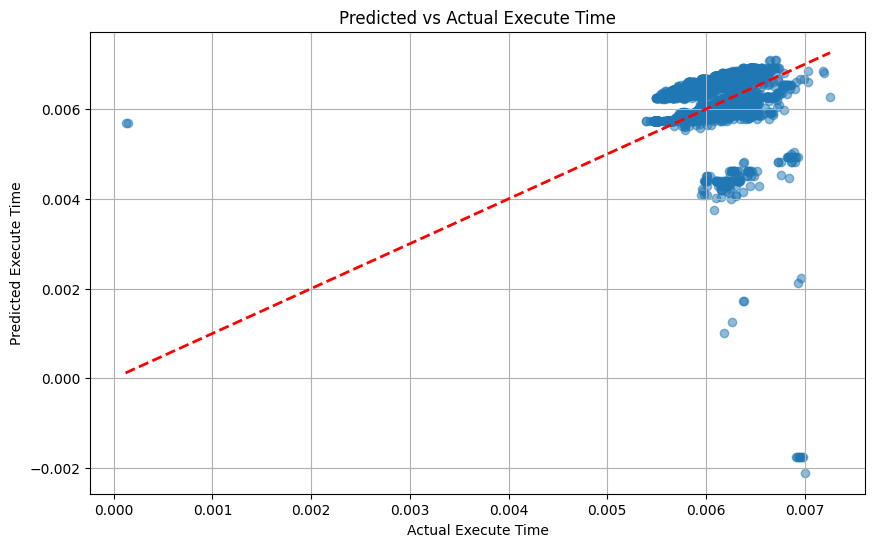

In [19]:
path1 = 'profiling/train/execution_stats_400_4_0.0_256_16_256_Qwen-Qwen2.5-0.5B_sharegpt.csv'

# # parse and concat all dataframes
df = parse_csv(path1)
df = format_data(df)
df.head()

X_test = df[['sum_decode_tokens', 'sum_uncached_prefill_tokens', 'max_uncached_prefill_tokens','num_prefills']]
y_test = df['execute_time']

# score
score = poly_model.score(X_test, y_test)
print("Test Score:", score)

# plot the predicted vs actual execute_time
import matplotlib.pyplot as plt
import numpy as np

predicted = poly_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Execute Time')
plt.ylabel('Predicted Execute Time')
plt.title('Predicted vs Actual Execute Time')
# plt.xscale('log')
# plt.yscale('log')
plt.grid(True)
plt.show()

In [12]:
['1' 'sum_decode_tokens' 'sum_prefill_tokens' 'max_prefill_tokens' 'num_prefills' 'sum_decode_tokens^2' 'sum_decode_tokens sum_prefill_tokens' 'sum_decode_tokens max_prefill_tokens' 'sum_decode_tokens num_prefills' 'sum_prefill_tokens^2' 'sum_prefill_tokens max_prefill_tokens' 'sum_prefill_tokens num_prefills' 'max_prefill_tokens^2' 'max_prefill_tokens num_prefills' 'num_prefills^2']

['1sum_decode_tokenssum_prefill_tokensmax_prefill_tokensnum_prefillssum_decode_tokens^2sum_decode_tokens sum_prefill_tokenssum_decode_tokens max_prefill_tokenssum_decode_tokens num_prefillssum_prefill_tokens^2sum_prefill_tokens max_prefill_tokenssum_prefill_tokens num_prefillsmax_prefill_tokens^2max_prefill_tokens num_prefillsnum_prefills^2']